Importy bibliotek

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from keras import Input
from keras import models, layers
import tensorflow as tf
import matplotlib.pyplot as plt

Wczytanie danych, przetwarzanie i inżynieria cech

In [34]:
FILE = 'data/stan_ustalony.csv'

# Lista cech (bazowa)
SELECTED_FEATURES = [
    'Active Power 1 (Cycle) [W]',
    'Reactive Power 1 (Cycle) [VAr]',
    'Power Factor 1 (Cycle) (Load)',
    'THD I1 (Cycle) [%]',
    'RMS - non-Fundamental I1 (Cycle) [A]',
    'Phasor Angle I1 (Cycle) [°]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]',
    'Active Power - per Harmonic 1 Harmonic 3 (Cycle) [W]',
    'RMS I1 (Cycle) [A]'
]

# Lista wszystkich urządzeń/klas
DEVICE_COLUMNS = [
    'coffee_machine', 'electric_kettle', 'fridge', 
    'laptop', 'mixer', 'phone_charger', 'printer', 
    'sandwich_maker', 'tv'
]

# Wczytanie surowych danych
df = pd.read_csv(FILE, sep=';', decimal=',')

# Funkcja czyszcząca wartości Power Factor (usuwanie 'CAP'/'IND')
def clean_power_factor(value):
    if isinstance(value, str):
        value = value.replace(' CAP', '').replace(' IND', '').strip()
        value = value.replace(',', '.')
    return value

# Czyszczenie kolumn Power Factor
PF_COLS = [col for col in SELECTED_FEATURES if 'Power Factor' in col]
for col in PF_COLS:
    df[col] = df[col].apply(clean_power_factor)

# Konwersja cech na typ numeryczny
for col in SELECTED_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ==============================================================================
# Obliczenia Mocy Deformacji 
# ==============================================================================
# Definicja kolumn pomocniczych
col_v = 'RMS V1N (Cycle) [V]'
col_i = 'RMS I1 (Cycle) [A]'
col_p = 'Active Power 1 (Cycle) [W]'
col_q = 'Reactive Power 1 (Cycle) [VAr]'

# Konwersja napięcia i prądu na float
df[col_v] = pd.to_numeric(df[col_v], errors='coerce')
df[col_i] = pd.to_numeric(df[col_i], errors='coerce')

# Obliczenie całkowitej mocy pozornej (S)
df['S_total_calc'] = df[col_v] * df[col_i]

# Obliczenie mocy deformacji (D) ze wzoru: D = sqrt(S^2 - P^2 - Q^2)
term_under_sqrt = (df['S_total_calc']**2) - (df[col_p]**2) - (df[col_q]**2)
new_feature_name = 'Budeanu Distortion Power [VAr]'
df[new_feature_name] = np.sqrt(np.maximum(term_under_sqrt, 0))

# Aktualizacja listy cech o moc deformacji
if new_feature_name not in SELECTED_FEATURES:
    SELECTED_FEATURES.append(new_feature_name)
    print(f"-> Dodano cechę: {new_feature_name}")
# ==============================================================================

# Weryfikacja liczby wierszy przed czyszczeniem
print(f"Liczba wierszy przed czyszczeniem: {len(df)}")

# Usunięcie wierszy z brakującymi danymi
df.dropna(subset=SELECTED_FEATURES, inplace=True)
print(f"Liczba wierszy po usunięciu NaN: {len(df)}")

if len(df) == 0:
    raise ValueError("Zbiór danych jest pusty! Sprawdź poprawność nazw kolumn.")

# Przygotowanie macierzy cech (X) i etykiet (y)
for col in DEVICE_COLUMNS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

X = df[SELECTED_FEATURES].values
y = df[DEVICE_COLUMNS].values

# Podział na zbiory treningowe/testowe i standaryzacja
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("-" * 30)
print(f"Wymiary X_train: {X_train_scaled.shape}, wymiary y_train: {y_train.shape}")
print(f"Liczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

-> Dodano cechę: Budeanu Distortion Power [VAr]
Liczba wierszy przed czyszczeniem: 497
Liczba wierszy po usunięciu NaN: 497
------------------------------
Wymiary X_train: (397, 11), wymiary y_train: (397, 9)
Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'THD I1 (Cycle) [%]', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Phasor Angle I1 (Cycle) [°]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Active Power - per Harmonic 1 Harmonic 3 (Cycle) [W]', 'RMS I1 (Cycle) [A]', 'Budeanu Distortion Power [VAr]']


Analiza rozkładu klas (urządzeń) w zbiorach treningowych i testowych

In [35]:
# Zliczanie aktywności urządzeń w zbiorach
train_counts = y_train.sum(axis=0)
test_counts = y_test.sum(axis=0)
total_counts = train_counts + test_counts

# Utworzenie ramki danych z podsumowaniem
distribution_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train (1s)': train_counts,
    'Test (1s)': test_counts,
    'Total (1s)': total_counts,
    'Share [%]': (total_counts / len(df) * 100).round(2)
})

# Sortowanie malejąco wg liczby wystąpień
distribution_df.sort_values(by='Total (1s)', ascending=False, inplace=True)

print("Szczegółowy rozkład aktywności urządzeń:")
try:
    display(distribution_df)
except NameError:
    print(distribution_df)

# Weryfikacja występowania pustych klas
zero_classes = distribution_df[distribution_df['Total (1s)'] == 0]['Device'].tolist()
if zero_classes:
    print(f"\nUWAGA: Brak próbek pozytywnych dla: {zero_classes}")
else:
    print("\nWszystkie urządzenia posiadają reprezentację w danych.")

Szczegółowy rozkład aktywności urządzeń:


,Device,Train (1s),Test (1s),Total (1s),Share [%]
2,fridge,312,80,392,78.87
8,tv,231,50,281,56.54
0,coffee_machine,69,11,80,16.10
3,laptop,65,12,77,15.49
5,phone_charger,37,5,42,8.45
7,sandwich_maker,20,7,27,5.43
1,electric_kettle,21,5,26,5.23
6,printer,17,4,21,4.23
4,mixer,5,1,6,1.21



Wszystkie urządzenia posiadają reprezentację w danych.


Random Forest

In [36]:
# Konfiguracja modelu (wykorzystanie wszystkich rdzeni CPU)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Dopasowanie modelu do danych treningowych
print("Rozpoczynam trening Random Forest...")
rf_model.fit(X_train_scaled, y_train)
print("Trening zakończony.")

# Predykcja na zbiorze testowym
y_pred = rf_model.predict(X_test_scaled)

# Obliczenie dokładności (Exact Match Ratio)
acc = accuracy_score(y_test, y_pred)
print(f"\nDokładność całkowita (Exact Match): {acc:.2%}\n")

# Generowanie raportu klasyfikacji
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=DEVICE_COLUMNS, zero_division=0))

Rozpoczynam trening Random Forest...
Trening zakończony.

Dokładność całkowita (Exact Match): 78.00%

Raport klasyfikacji:
                 precision    recall  f1-score   support

 coffee_machine       0.92      1.00      0.96        11
electric_kettle       1.00      1.00      1.00         5
         fridge       0.93      0.95      0.94        80
         laptop       0.89      0.67      0.76        12
          mixer       1.00      1.00      1.00         1
  phone_charger       0.80      0.80      0.80         5
        printer       1.00      0.50      0.67         4
 sandwich_maker       0.88      1.00      0.93         7
             tv       0.94      0.88      0.91        50

      micro avg       0.92      0.90      0.91       175
      macro avg       0.93      0.87      0.88       175
   weighted avg       0.92      0.90      0.91       175
    samples avg       0.93      0.91      0.91       175



Deep Neural Network (PyTorch)

TensorFlow version: 2.19.0
Dostępne urządzenia: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,145 (12.29 KB)

 Trainable params: 3,145 (12.29 KB)

 Non-trainable params: 0 (0.00 B)


Rozpoczynam trening sieci neuronowej...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1972 - loss: 0.9932 - val_accuracy: 0.3250 - val_loss: 0.9595
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2765 - loss: 1.0086 - val_accuracy: 0.4500 - val_loss: 0.9148
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2610 - loss: 0.9172 - val_accuracy: 0.5000 - val_loss: 0.8797
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3840 - loss: 0.9241 - val_accuracy: 0.5250 - val_loss: 0.8507
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4308 - loss: 0.8630 - val_accuracy: 0.5000 - val_loss: 0.8191
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4026 - loss: 0.8008 - val_accuracy: 0.5250 - val_loss: 0.7936
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4142 - loss: 0.8116 - val_accuracy: 0.5250 - val_loss: 0.7675
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4040 - loss:

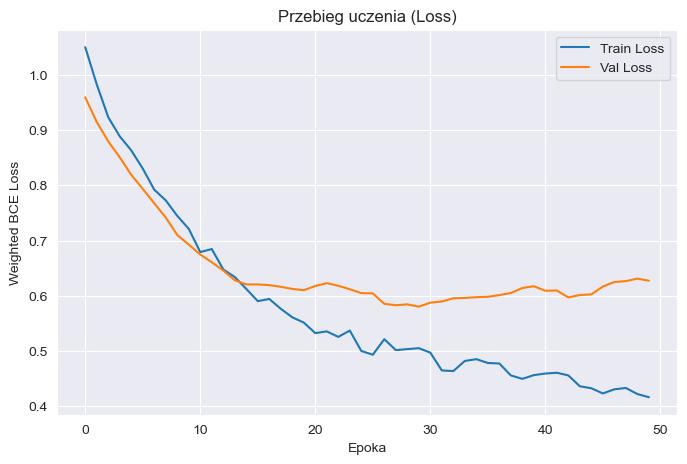

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Dokładność DNN (Exact Match): 40.00%
Raport klasyfikacji:
                 precision    recall  f1-score   support

 coffee_machine       0.52      1.00      0.69        11
electric_kettle       1.00      1.00      1.00         5
         fridge       0.93      0.69      0.79        80
         laptop       0.23      0.58      0.33        12
          mixer       0.06      1.00      0.11         1
  phone_charger       0.11      0.80      0.20         5
        printer       0.57      1.00      0.73         4
 sandwich_maker       0.42      0.71      0.53         7
             tv       0.90      0.90      0.90        50

      micro avg       0.58      0.78      0.67       175
      macro avg       0.53      0.85      0.59       175
   weighted avg       0.79      0.78      0.76       175
    samples avg       0.69      0.79      0.71       175



In [37]:
# Sprawdzenie dostępności GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"Dostępne urządzenia: {tf.config.list_physical_devices()}")

# ==============================================================================
# Obsługa niezbalansowanych klas (Ważenie)
# ==============================================================================
# Obliczenie wag dla pozytywnych klas (rzadsze urządzenia dostają wyższą wagę)
# Wzór: pos_weight = (liczba_zer / liczba_jedynek)
pos_counts = np.sum(y_train, axis=0)
neg_counts = len(y_train) - pos_counts
pos_weights = (neg_counts + 1e-5) / (pos_counts + 1e-5) # 1e-5 zapobiega dzieleniu przez 0

# Konwersja wag na stałą TensorFlow
pos_weights_tf = tf.constant(pos_weights, dtype=tf.float32)

# Niestandardowa funkcja straty z obsługą pos_weight
def weighted_bce_loss(y_true, y_pred):
    # y_pred to "logits" (wartości przed sigmoidem)
    return tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true, 
        logits=y_pred, 
        pos_weight=pos_weights_tf
    )

# ==============================================================================
# Definicja Modelu
# ==============================================================================
input_dim = X_train_scaled.shape[1]
output_dim = y_train.shape[1]

model = models.Sequential([
    # Warstwa wejściowa -> Ukryta 1
    Input(shape=(X_train_scaled.shape[1],)),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3), # Zapobiega overfittingowi
    
    # Ukryta 1 -> Ukryta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Warstwa wyjściowa
    # UWAGA: Brak aktywacji 'sigmoid' tutaj, ponieważ funkcja straty 
    # weighted_cross_entropy_with_logits oczekuje tzw. logits (surowych wartości)
    layers.Dense(output_dim) 
])

# Kompilacja modelu
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_bce_loss,
    metrics=['accuracy'] # Accuracy w multi-label jest tylko poglądowe
)

model.summary()

# ==============================================================================
# Trening
# ==============================================================================
EPOCHS = 50
BATCH_SIZE = 32

print("\nRozpoczynam trening sieci neuronowej...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # Opcjonalnie: użycie 10% danych treningowych do walidacji
    verbose=1
)

# Wykres funkcji straty
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Weighted BCE Loss')
plt.legend()
plt.grid(True)
plt.show()

# ==============================================================================
# Ewaluacja
# ==============================================================================
# Predykcja (zwraca logits)
logits = model.predict(X_test_scaled)

# Konwersja logits -> prawdopodobieństwa (Sigmoid)
probs = tf.nn.sigmoid(logits).numpy()

# Binaryzacja wyników (Próg 0.5)
y_pred_numpy = (probs > 0.5).astype(int)

# Raport wyników
from sklearn.metrics import accuracy_score, classification_report

acc_dnn = accuracy_score(y_test, y_pred_numpy)
print(f"\nDokładność DNN (Exact Match): {acc_dnn:.2%}")
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred_numpy, target_names=DEVICE_COLUMNS, zero_division=0))